In [32]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
load_dotenv()

os.environ["GORQ_API_KEY"] = os.getenv("GROQ_API_KEY")

model = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")

In [33]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

In [34]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

In [35]:
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

In [36]:
from langgraph.graph import END
# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

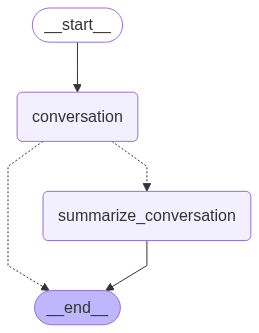

In [37]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation",summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue, {"summarize_conversation": "summarize_conversation", END: END})
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Threads

The checkpointer saves the state at each step as a checkpoint.

These saved checkpoints can be grouped into a `thread` of conversation.

Think about Slack as an analog: different channels carry different conversations.

Threads are like Slack channels, capturing grouped collections of state (e.g., conversation).

Below, we use `configurable` to set a thread ID.

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbadf3b379c2ee621adfd1_chatbot-summarization1.png)

In [38]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello Lance! It's nice to meet you! Is there something I can help you with, or would you like to chat?
================================== Ai Message ==================================

Your name is Lance! You told me that when we first started chatting. How's your day going so far, Lance?
================================== Ai Message ==================================

Go Niners! The San Francisco 49ers have a rich history and a loyal fan base. Who's your favorite player, past or present? Do you have a favorite memory of watching the team play?


In [39]:
graph.get_state(config).values.get("summary", "")

''

In [40]:
graph.get_state(config).values.get("messages", "")

[HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='3c18fb9a-3f53-47ae-aeea-f915eee41960'),
 AIMessage(content="Hello Lance! It's nice to meet you! Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 14, 'total_tokens': 40, 'completion_time': 0.051485826, 'prompt_time': 0.002262509, 'queue_time': 0.045132650999999996, 'total_time': 0.053748335}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_37da608fc1', 'finish_reason': 'stop', 'logprobs': None}, id='run--29c9b501-dc6f-47ae-a0c3-b5ac117ed305-0', usage_metadata={'input_tokens': 14, 'output_tokens': 26, 'total_tokens': 40}),
 HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='d5ddcb2f-49ac-40e3-9063-e7f9cf796f8f'),
 AIMessage(content="Your name is Lance! You told me that when we first started chatting. How's your d

In [41]:
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Nick Bosa is an incredible player! He's definitely one of the top defensive players in the league. As for being the highest-paid defensive player, that's correct! In 2022, Nick Bosa signed a massive 5-year, $170 million contract extension with the 49ers, which made him the highest-paid defensive player in the NFL at the time. He's a dominant force on the field, and it's no surprise he's getting paid like a top player! What do you think about the 49ers' chances this season?


In [42]:
graph.get_state(config).values.get("messages", "")

[HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?", additional_kwargs={}, response_metadata={}, id='fab3b974-2eaa-4bce-906f-bd8fd420eab7'),
 AIMessage(content="Nick Bosa is an incredible player! He's definitely one of the top defensive players in the league. As for being the highest-paid defensive player, that's correct! In 2022, Nick Bosa signed a massive 5-year, $170 million contract extension with the 49ers, which made him the highest-paid defensive player in the NFL at the time. He's a dominant force on the field, and it's no surprise he's getting paid like a top player! What do you think about the 49ers' chances this season?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 110, 'prompt_tokens': 160, 'total_tokens': 270, 'completion_time': 0.217444139, 'prompt_time': 0.006201739, 'queue_time': 0.045873071, 'total_time': 0.223645878}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp

In [43]:
graph.get_state(config).values.get("summary","")

"Here's a summary of our conversation:\n\n* You introduced yourself as Lance.\n* We confirmed that your name is Lance.\n* You mentioned that you're a fan of the San Francisco 49ers.\n* You expressed admiration for Nick Bosa, a defensive player for the 49ers.\n* We discussed Nick Bosa's contract and his status as one of the highest-paid defensive players in the NFL.\n\nLet me know if there's anything else I can help with!"